# DEEP LEARNING

### Dataset Preparation: Download and transform the CIFAR-10 dataset.

In [2]:
pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/13/24/23cdf7e7dc33e5c01588c315f8424d31afa9edb05a80168f3d44f7178ff7/torchvision-0.16.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.1 MB 163.8 kB/s eta 0:00:07
   - -------------------------------------- 0.0/1.1 MB 151.3 kB/s eta 0:00:08
   - -------------------------------------- 0.0/1.1 MB 151.3 kB/s eta 0:00:08
   -- ------------------------------------- 0.1/1.1 MB 172.4 kB/s eta 0:00:07
   -- ------------------------------------- 0.1/1.1 MB 187.3 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/1.1 MB 187.3 kB/s eta 0:00:06
   ---- -------------------------------

### Import Data

In [1]:
import os
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


### Normalize

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training and test data
data_dir = './data'
trainset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

# Create the DataLoaders
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Set the classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Show Sampels

Label:  bird (tensor(2))


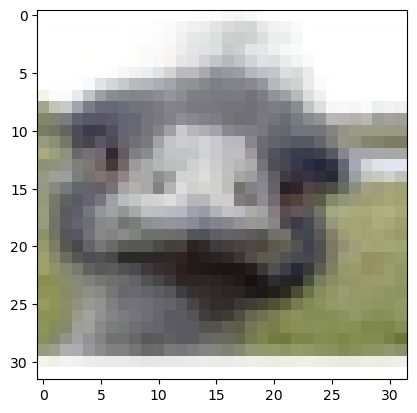

In [3]:
# Set the default figure background color to white
plt.rcParams['figure.facecolor'] = '#ffffff'

# Function to un-normalize and display an image
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5
    # Convert from Tensor image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # Show the image
    plt.show()

# Function to show an example with the corresponding label
def show_example(img, label):
    print('Label: ', classes[label], "(" + str(label) + ")")
    imshow(img)

# Get some random training images with their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Choose a random image to show
img = images[0]
label = labels[0]

# Call the show_example function
show_example(img, label)

## GoogLeNet 

### Inception

In [4]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, out1x1pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out1x1pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

### Architecture

In [5]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogLeNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

# Create an instance of the GoogLeNet model
googlenet = GoogLeNet()

# Print the model architecture
print(googlenet)


GoogLeNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionModule(
    (branch1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (branch2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (branch3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (branch4): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (1): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (inception3b): InceptionM

### Training Loop

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=0.001)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 3.023
[1,   200] loss: 2.284
[1,   300] loss: 2.088
[1,   400] loss: 2.016
[1,   500] loss: 2.005
[1,   600] loss: 1.941
[1,   700] loss: 1.882
[1,   800] loss: 1.958
[1,   900] loss: 1.851
[1,  1000] loss: 1.830
[1,  1100] loss: 1.798
[1,  1200] loss: 1.721
[1,  1300] loss: 1.694
[1,  1400] loss: 1.640
[1,  1500] loss: 1.667
[2,   100] loss: 1.527
[2,   200] loss: 1.535
[2,   300] loss: 1.494
[2,   400] loss: 1.460
[2,   500] loss: 1.446
[2,   600] loss: 1.436
[2,   700] loss: 1.473
[2,   800] loss: 1.467
[2,   900] loss: 1.386
[2,  1000] loss: 1.366
[2,  1100] loss: 1.318
[2,  1200] loss: 1.321
[2,  1300] loss: 1.335
[2,  1400] loss: 1.288
[2,  1500] loss: 1.314
Finished Training


### Accuracy

In [7]:
# Test the trained model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = googlenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: %d %%' % (100 * correct / total))

Accuracy on the test images: 53 %


## ResNet

###  Basic block

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
            
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

### Architecture

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Function to create ResNet-18
def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# Create an instance of the ResNet-18 model
resnet = resnet18()

# Print the model architecture
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

### Training Loop

In [11]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# Train the model for 2 epochs
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.065
[1,   200] loss: 1.721
[1,   300] loss: 1.606
[1,   400] loss: 1.576
[1,   500] loss: 1.525
[1,   600] loss: 1.434
[1,   700] loss: 1.387
[1,   800] loss: 1.336
[1,   900] loss: 1.322
[1,  1000] loss: 1.266
[1,  1100] loss: 1.242
[1,  1200] loss: 1.217
[1,  1300] loss: 1.201
[1,  1400] loss: 1.157
[1,  1500] loss: 1.127
[2,   100] loss: 1.076
[2,   200] loss: 1.030
[2,   300] loss: 0.984
[2,   400] loss: 0.971
[2,   500] loss: 1.016
[2,   600] loss: 0.958
[2,   700] loss: 0.968
[2,   800] loss: 0.961
[2,   900] loss: 0.900
[2,  1000] loss: 0.914
[2,  1100] loss: 0.817
[2,  1200] loss: 0.866
[2,  1300] loss: 0.849
[2,  1400] loss: 0.865
[2,  1500] loss: 0.852
Finished Training


### Accuracy

In [12]:
# Test the trained model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: %d %%' % (100 * correct / total))


Accuracy on the test images: 70 %
